In [1]:
import warnings
warnings.simplefilter('ignore')
import tensorflow as tf

In [2]:
print("Is GPU available?", tf.test.is_gpu_available())
print("TF version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available? True
TF version: 2.3.1
Keras version: 2.4.0


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random

In [4]:
class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.f1 = tf.keras.layers.Dense(512, activation='relu')
        self.f2 = tf.keras.layers.Dense(512, activation='relu')
        self.v =  tf.keras.layers.Dense(1, activation=None)

    def call(self, state, action, goal):
        x = self.f1(tf.concat([state, action, goal], axis=1))
        x = self.f2(x)
        x = self.v(x)
        return x


class Actor(tf.keras.Model):
    def __init__(self, no_action):
        super(Actor, self).__init__()    
        self.f1 = tf.keras.layers.Dense(512, activation='relu')
        self.f2 = tf.keras.layers.Dense(512, activation='relu')
        self.mu =  tf.keras.layers.Dense(no_action, activation='tanh')

    def call(self, state, goal):
        x = self.f1(tf.concat([state, goal], axis=1))
        x = self.f2(x)
        x = self.mu(x)  
        return x

In [5]:
class Agent():
    def __init__(self, n_actions, min_action, max_action):
        self.actor_main = Actor(n_actions)
        self.actor_target = Actor(n_actions)
        self.critic_main = Critic()
        self.critic_main2 = Critic()
        self.critic_target = Critic()
        self.critic_target2 = Critic()
        self.batch_size = 64
        self.n_actions = n_actions
        self.a_opt = tf.keras.optimizers.Adam(0.001)
        self.c_opt1 = tf.keras.optimizers.Adam(0.002)
        self.c_opt2 = tf.keras.optimizers.Adam(0.002)
        self.memory = deque(maxlen=100000)
        self.trainstep = 0
        self.gamma = 0.99
        self.min_action = min_action
        self.max_action = max_action
        self.actor_update_steps = 2
        self.warmup = 200
        self.actor_target.compile(optimizer=self.a_opt)
        self.critic_target.compile(optimizer=self.c_opt1)
        self.critic_target2.compile(optimizer=self.c_opt2)
        self.tau = 0.005


    def act(self, state, desired_goal, evaluate=False):
        if self.trainstep > self.warmup:
            evaluate = True
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        goal = tf.convert_to_tensor([desired_goal], dtype=tf.float32)
        actions = self.actor_main(state, goal)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=0.1)

        actions = self.max_action * (tf.clip_by_value(actions, self.min_action, self.max_action))
        
        return actions[0]
    
    def store(self, state, action, reward, n_state, done, desired_goal):
        pack = [state, action, reward, n_state, 1 - int(done), desired_goal]
        self.memory.append(pack)
    
    def take_data(self, batch_size):
        pack = random.sample(self.memory, batch_size)
        states = []
        actions = []
        rewards = []
        n_states = []
        dones = []
        goals = []
        for i in range(batch_size):
            states.append(pack[i][0])
            actions.append(pack[i][1])
            rewards.append(pack[i][2])
            n_states.append(pack[i][3])
            dones.append(pack[i][4])
            goals.append(pack[i][5])
        return states, actions, rewards, n_states, dones, goals

    def update_target(self, tau=None):

        if tau is None:
            tau = self.tau

        weights1 = []
        targets1 = self.actor_target.weights
        for i, weight in enumerate(self.actor_main.weights):
            weights1.append(weight * tau + targets1[i]*(1-tau))
        self.actor_target.set_weights(weights1)

        weights2 = []
        targets2 = self.critic_target.weights
        for i, weight in enumerate(self.critic_main.weights):
            weights2.append(weight * tau + targets2[i]*(1-tau))
        self.critic_target.set_weights(weights2)


        weights3 = []
        targets3 = self.critic_target2.weights
        for i, weight in enumerate(self.critic_main2.weights):
            weights3.append(weight * tau + targets3[i]*(1-tau))
        self.critic_target2.set_weights(weights3)
    
    def upgrade(self):
        if len(self.memory) < 2*self.batch_size:
            return 


        states, actions, rewards, n_states, dones, goals = self.take_data(self.batch_size)

        states = tf.convert_to_tensor(states, dtype=tf.float32)
        n_states = tf.convert_to_tensor(n_states, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        goals = tf.convert_to_tensor(goals, dtype=tf.float32)

        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:

            target_actions = self.actor_target(n_states, goals)
            target_actions += tf.clip_by_value(tf.random.normal(shape=[*np.shape(target_actions)], mean=0.0, stddev=0.2), -0.5, 0.5)
            target_actions = self.max_action * (tf.clip_by_value(target_actions, self.min_action, self.max_action))


            target_next_state_values = tf.squeeze(self.critic_target(n_states, target_actions, goals), 1)
            target_next_state_values2 = tf.squeeze(self.critic_target2(n_states, target_actions, goals), 1)

            critic_value = tf.squeeze(self.critic_main(states, actions, goals), 1)
            critic_value2 = tf.squeeze(self.critic_main2(states, actions, goals), 1)

            next_state_target_value = tf.math.minimum(target_next_state_values, target_next_state_values2)

            target_values = rewards + self.gamma * next_state_target_value * dones
            critic_loss1 = tf.keras.losses.MSE(target_values, critic_value)
            critic_loss2 = tf.keras.losses.MSE(target_values, critic_value2)




        grads1 = tape1.gradient(critic_loss1, self.critic_main.trainable_variables)
        grads2 = tape2.gradient(critic_loss2, self.critic_main2.trainable_variables)

        self.c_opt1.apply_gradients(zip(grads1, self.critic_main.trainable_variables))
        self.c_opt2.apply_gradients(zip(grads2, self.critic_main2.trainable_variables))


        self.trainstep +=1

        if self.trainstep % self.actor_update_steps == 0:

            with tf.GradientTape() as tape3:

                new_policy_actions = self.actor_main(states, goals)
                actor_loss = -self.critic_main(states, new_policy_actions, goals)
                actor_loss = tf.math.reduce_mean(actor_loss)

            grads3 = tape3.gradient(actor_loss, self.actor_main.trainable_variables)
            self.a_opt.apply_gradients(zip(grads3, self.actor_main.trainable_variables))

        self.update_target()

In [6]:
import gym
env = gym.make('FetchReach-v1')

print('Min_action:', env.action_space.low[0])
print('Max_action: ', env.action_space.high[0])
print('States: ', env.observation_space.shape)
print('Actions: ', env.action_space.shape)

Min_action: -1.0
Max_action:  1.0
States:  None
Actions:  (4,)


In [7]:
### My implementation of TD3 + HER

agent = Agent(4, -1.0, 1.0)

n_episodes = 1200
scores = []
avg_scores = []

for i in range(n_episodes):
    score = 0
    done = False
    dic = env.reset()
    state, desired_goal = dic['observation'], dic['desired_goal']
    temp = []
    
    while not done:
        action = agent.act(state, desired_goal)
        dic, reward, done, info = env.step(action)
        n_state, achieved_goal = dic['observation'], dic['achieved_goal']
        
        agent.store(state, action, reward, n_state, done, desired_goal)
        temp.append([state, action, reward, n_state, done, achieved_goal, info])
        
        state = n_state
        score += reward
        agent.upgrade()
        
    if (achieved_goal != desired_goal).all():
        desired_goal = achieved_goal
        for t in range(len(temp)):
            state, action, reward, n_state, done, achieved_goal, info = temp[t]
            reward = env.compute_reward(desired_goal, achieved_goal, info)
            done = False if reward else True
            agent.store(state, action, reward, n_state, done, desired_goal)
            #print(reward, done, achieved_goal, desired_goal)
    
    scores.append(score)
    avg = np.mean(scores[-100:])
    avg_scores.append(avg)
    print(f'Episode {i}  Score {score}  AVG {avg}')

env.close()

Episode 0  Score -50.0  AVG -50.0
Episode 1  Score -50.0  AVG -50.0
Episode 2  Score -50.0  AVG -50.0
Episode 3  Score -50.0  AVG -50.0
Episode 4  Score -50.0  AVG -50.0
Episode 5  Score -50.0  AVG -50.0
Episode 6  Score -50.0  AVG -50.0
Episode 7  Score -50.0  AVG -50.0
Episode 8  Score -50.0  AVG -50.0
Episode 9  Score -50.0  AVG -50.0
Episode 10  Score -50.0  AVG -50.0
Episode 11  Score -50.0  AVG -50.0
Episode 12  Score -50.0  AVG -50.0
Episode 13  Score -50.0  AVG -50.0
Episode 14  Score -50.0  AVG -50.0
Episode 15  Score -50.0  AVG -50.0
Episode 16  Score -50.0  AVG -50.0
Episode 17  Score -50.0  AVG -50.0
Episode 18  Score -50.0  AVG -50.0
Episode 19  Score -50.0  AVG -50.0
Episode 20  Score -50.0  AVG -50.0
Episode 21  Score -50.0  AVG -50.0
Episode 22  Score -50.0  AVG -50.0
Episode 23  Score -50.0  AVG -50.0
Episode 24  Score -50.0  AVG -50.0
Episode 25  Score -50.0  AVG -50.0
Episode 26  Score -50.0  AVG -50.0
Episode 27  Score -50.0  AVG -50.0
Episode 28  Score -50.0  AVG -

Episode 206  Score -50.0  AVG -49.58
Episode 207  Score -47.0  AVG -49.55
Episode 208  Score -50.0  AVG -49.55
Episode 209  Score -50.0  AVG -49.55
Episode 210  Score -47.0  AVG -49.52
Episode 211  Score -50.0  AVG -49.52
Episode 212  Score -50.0  AVG -49.52
Episode 213  Score -50.0  AVG -49.52
Episode 214  Score -50.0  AVG -49.52
Episode 215  Score -50.0  AVG -49.54
Episode 216  Score -38.0  AVG -49.44
Episode 217  Score -50.0  AVG -49.46
Episode 218  Score -50.0  AVG -49.48
Episode 219  Score -50.0  AVG -49.48
Episode 220  Score -50.0  AVG -49.48
Episode 221  Score -50.0  AVG -49.48
Episode 222  Score -50.0  AVG -49.48
Episode 223  Score -50.0  AVG -49.48
Episode 224  Score -42.0  AVG -49.41
Episode 225  Score -50.0  AVG -49.41
Episode 226  Score -48.0  AVG -49.39
Episode 227  Score -50.0  AVG -49.39
Episode 228  Score -42.0  AVG -49.31
Episode 229  Score -50.0  AVG -49.31
Episode 230  Score -47.0  AVG -49.28
Episode 231  Score -50.0  AVG -49.28
Episode 232  Score -50.0  AVG -49.28
E

Episode 428  Score -16.0  AVG -39.35
Episode 429  Score -4.0  AVG -38.98
Episode 430  Score -14.0  AVG -38.95
Episode 431  Score -50.0  AVG -38.95
Episode 432  Score -36.0  AVG -38.81
Episode 433  Score -28.0  AVG -38.59
Episode 434  Score -21.0  AVG -38.3
Episode 435  Score -3.0  AVG -37.83
Episode 436  Score -25.0  AVG -37.58
Episode 437  Score -24.0  AVG -37.32
Episode 438  Score -18.0  AVG -37.0
Episode 439  Score -29.0  AVG -36.79
Episode 440  Score -16.0  AVG -36.45
Episode 441  Score -17.0  AVG -36.2
Episode 442  Score -4.0  AVG -35.74
Episode 443  Score -15.0  AVG -35.39
Episode 444  Score -12.0  AVG -35.15
Episode 445  Score -29.0  AVG -35.01
Episode 446  Score -16.0  AVG -34.95
Episode 447  Score -28.0  AVG -34.89
Episode 448  Score -18.0  AVG -34.57
Episode 449  Score -24.0  AVG -34.32
Episode 450  Score -10.0  AVG -33.97
Episode 451  Score -3.0  AVG -33.5
Episode 452  Score -23.0  AVG -33.4
Episode 453  Score -13.0  AVG -33.24
Episode 454  Score -35.0  AVG -33.15
Episode 45

Episode 659  Score -28.0  AVG -5.83
Episode 660  Score -10.0  AVG -5.9
Episode 661  Score -3.0  AVG -5.75
Episode 662  Score -3.0  AVG -5.69
Episode 663  Score -2.0  AVG -5.66
Episode 664  Score -4.0  AVG -5.5
Episode 665  Score 0.0  AVG -5.48
Episode 666  Score -3.0  AVG -5.5
Episode 667  Score -2.0  AVG -5.48
Episode 668  Score -19.0  AVG -5.53
Episode 669  Score -4.0  AVG -5.32
Episode 670  Score -2.0  AVG -5.31
Episode 671  Score -2.0  AVG -5.32
Episode 672  Score 0.0  AVG -5.3
Episode 673  Score -2.0  AVG -5.3
Episode 674  Score -3.0  AVG -5.31
Episode 675  Score -25.0  AVG -5.44
Episode 676  Score -2.0  AVG -5.42
Episode 677  Score -1.0  AVG -5.35
Episode 678  Score -7.0  AVG -5.3
Episode 679  Score -2.0  AVG -5.3
Episode 680  Score 0.0  AVG -5.0
Episode 681  Score 0.0  AVG -4.73
Episode 682  Score -1.0  AVG -4.69
Episode 683  Score -4.0  AVG -4.6
Episode 684  Score -3.0  AVG -4.45
Episode 685  Score -14.0  AVG -4.57
Episode 686  Score -42.0  AVG -4.9
Episode 687  Score -33.0  AV

Episode 894  Score -3.0  AVG -4.45
Episode 895  Score -3.0  AVG -4.23
Episode 896  Score -5.0  AVG -4.26
Episode 897  Score -2.0  AVG -4.25
Episode 898  Score -2.0  AVG -4.22
Episode 899  Score -2.0  AVG -4.08
Episode 900  Score -2.0  AVG -4.08
Episode 901  Score -2.0  AVG -4.08
Episode 902  Score -4.0  AVG -4.1
Episode 903  Score -43.0  AVG -4.51
Episode 904  Score -50.0  AVG -4.98
Episode 905  Score -5.0  AVG -5.01
Episode 906  Score -2.0  AVG -5.02
Episode 907  Score 0.0  AVG -4.99
Episode 908  Score -11.0  AVG -5.07
Episode 909  Score -1.0  AVG -5.07
Episode 910  Score -10.0  AVG -5.02
Episode 911  Score -21.0  AVG -5.21
Episode 912  Score 0.0  AVG -5.21
Episode 913  Score -2.0  AVG -5.2
Episode 914  Score -18.0  AVG -5.36
Episode 915  Score 0.0  AVG -5.33
Episode 916  Score -2.0  AVG -5.34
Episode 917  Score -2.0  AVG -5.33
Episode 918  Score -11.0  AVG -5.41
Episode 919  Score -19.0  AVG -5.58
Episode 920  Score -1.0  AVG -5.57
Episode 921  Score -2.0  AVG -5.49
Episode 922  Scor

Episode 1126  Score -3.0  AVG -3.2
Episode 1127  Score 0.0  AVG -3.17
Episode 1128  Score -3.0  AVG -3.18
Episode 1129  Score -2.0  AVG -3.18
Episode 1130  Score -3.0  AVG -3.2
Episode 1131  Score -2.0  AVG -3.21
Episode 1132  Score -2.0  AVG -3.22
Episode 1133  Score -2.0  AVG -3.22
Episode 1134  Score -2.0  AVG -3.22
Episode 1135  Score -1.0  AVG -3.2
Episode 1136  Score -3.0  AVG -3.21
Episode 1137  Score -3.0  AVG -3.21
Episode 1138  Score -2.0  AVG -3.21
Episode 1139  Score -2.0  AVG -3.2
Episode 1140  Score -1.0  AVG -3.19
Episode 1141  Score -2.0  AVG -3.18
Episode 1142  Score -2.0  AVG -3.03
Episode 1143  Score -1.0  AVG -3.0
Episode 1144  Score -2.0  AVG -2.99
Episode 1145  Score -2.0  AVG -2.99
Episode 1146  Score -1.0  AVG -2.99
Episode 1147  Score -2.0  AVG -2.98
Episode 1148  Score -3.0  AVG -3.0
Episode 1149  Score -2.0  AVG -3.0
Episode 1150  Score -1.0  AVG -2.98
Episode 1151  Score -2.0  AVG -2.98
Episode 1152  Score -2.0  AVG -2.98
Episode 1153  Score -2.0  AVG -2.98


Text(0, 0.5, 'Avg rewards')

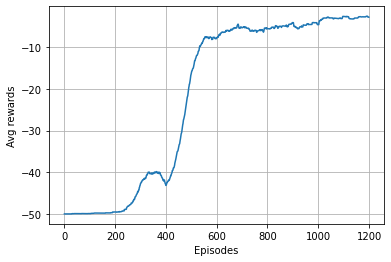

In [8]:
plt.plot(avg_scores)
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Avg rewards')

In [11]:
env = gym.make('FetchReach-v1')

for i in range(10):
    dic = env.reset()
    state, desired_goal = dic['observation'], dic['desired_goal']
    done = False
    
    while not done:
        action = agent.act(state, desired_goal, True)
        dic, _, done, _ = env.step(action)
        n_state = dic['observation']
        state = n_state
        env.render()
env.close()

Creating window glfw


In [10]:
agent.actor_main.save_weights('actor_weights.h5')